In [1]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import time

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import collab2.foraging.toolkit as ft
from collab2.foraging.toolkit import (
    dataObject,
    plot_predictor,
    rescale_to_grid,
    subset_frames_evenly_spaced,
)
from collab2.utils import find_repo_root

logging.basicConfig(format="%(message)s", level=logging.INFO)

root = find_repo_root()

# users can ignore smoke_test -- it's for automatic testing on GitHub,
# to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
smoke_test = True
frames = 150 if smoke_test else 300
frames_sps = 150 if smoke_test else 2300
sampling_rate = 0.001 if smoke_test else 0.01

notebook_starts = time.time()

In [2]:
ducks_raw = pd.read_csv(
    os.path.join(
        root,
        "data/foraging/central_park_birds_cleaned_2022/20221215122046189_-5_25_bone.avi.hand_checked_cleaned_df.csv",
    )
)
sparrows_raw = pd.read_csv(
    os.path.join(
        root,
        "data/foraging/central_park_birds_cleaned_2022/20221229124843603_n5_25_bone.avi.hand_checked_cleaned_df.csv",
    )
)

ducks_raw = ducks_raw.rename(columns={"bird": "forager"})
sparrows_raw = sparrows_raw.rename(columns={"bird": "forager"})

ducks_sub = ft.subset_frames_evenly_spaced(ducks_raw, frames)
ducks_sub = ft.rescale_to_grid(ducks_sub, 90)
ducks_object = dataObject(foragersDF = ducks_sub)

sps_sub = ft.subset_frames_evenly_spaced(sparrows_raw, frames_sps)
sps_sub = sps_sub[sps_sub["time"] <= 800] #to make datsets of similar size
sps_sub = ft.rescale_to_grid(sps_sub, 90)
sps_object = dataObject(foragersDF = sps_sub)   


original_frames: 1451
original_shape: (8867, 4)
resulting_frames: 150
resulting_shape: (933, 4)
original_frames: 11550
original_shape: (22821, 4)
resulting_frames: 141
resulting_shape: (323, 4)


/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/utils.py:62: UserWarning: 
                    Missing frames encountered for forager 0, adding NaN fillers.
                    The default behavior of predictor/score generating functions is
                    to ignore foragers with missing positional data. To modify, see documentation of
                    `derive_predictors_and_scores` and `generate_local_windows`
                    
  warnings.warn(
/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/utils.py:62: UserWarning: 
                    Missing frames encountered for forager 1, adding NaN fillers.
                    The default behavior of predictor/score generating functions is
                    to ignore foragers with missing positional data. To modify, see documentation of
                    `derive_predictors_and_scores` and `generate_local_windows`
                    
  warnings.warn(
/home/rafal/s78projects/collab-creatures/col

In [3]:
datalist = ducks_object.foragers
source = ducks_sub

# we do this as central park birds data contains many birds flying away

def test_data_object_correctness(datalist, source):
    for forager in source['forager'].unique():
        for time in source['time'].unique():

            data = datalist[forager][datalist[forager]["time"] == time]
            sourced = source[(source["forager"] == forager) & (source["time"] == time)]
            
            if len(sourced) > 0:
                assert len(sourced) == 1
                assert sourced["x"].values == data["x"].values
                assert sourced["y"].values == data["y"].values

            if len(sourced) == 0:
                assert data["x"].isna().sum() == len(data)
                
    print("Data tests passed")

test_data_object_correctness(ducks_object.foragers, ducks_sub)
test_data_object_correctness(sps_object.foragers, sps_sub)


Data tests passed
Data tests passed


2024-10-08 09:44:23,505 - proximity completed in 3.13 seconds.
2024-10-08 09:44:24,423 - access completed in 0.92 seconds.
2024-10-08 09:44:25,211 - nextStep_linear completed in 0.79 seconds.
2024-10-08 09:44:25,869 - nextStep_sublinear completed in 0.66 seconds.
/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/derive.py:56: UserWarning: 
                      Dropped 20922/944778 frames from `derivedDF` due to NaN values.
                      Missing values can arise when computations depend on next/previous step positions
                      that are unavailable. See documentation of the corresponding predictor/score generating
                      functions for more information.
                      
  warnings.warn(
2024-10-08 09:44:28,303 - proximity completed in 0.88 seconds.
2024-10-08 09:44:28,992 - access completed in 0.69 seconds.
2024-10-08 09:44:29,317 - nextStep_linear completed in 0.32 seconds.
2024-10-08 09:44:29,632 - nextStep_sublinear completed i

,x,y,distance_to_forager,time,forager,proximity,access,distance_to_next_step,nextStep_linear,nextStep_sublinear,proximity_scaled,access_scaled,nextStep_linear_scaled,nextStep_sublinear_scaled
0,52,18,20.000000,56,0,0.004795,0.018316,20.000000,0.000000,0.000000,0.502397,0.000000,0.000000,0.000000
1,53,12,19.924859,56,0,0.000058,0.018593,19.924859,0.003757,0.001880,0.500029,0.000283,0.003757,0.001880
2,53,13,19.646883,56,0,0.000138,0.019656,19.646883,0.017656,0.008867,0.500069,0.001365,0.017656,0.008867
3,53,14,19.416488,56,0,0.000324,0.020583,19.416488,0.029176,0.014696,0.500162,0.002310,0.029176,0.014696
4,53,15,19.235384,56,0,0.000746,0.021342,19.235384,0.038231,0.019302,0.500373,0.003083,0.038231,0.019302


In [10]:
# let's get a feel for the distance distributions
duck_distances = ft.foragers_to_forager_distances(ducks_object)
sps_distances = ft.foragers_to_forager_distances(sps_object)


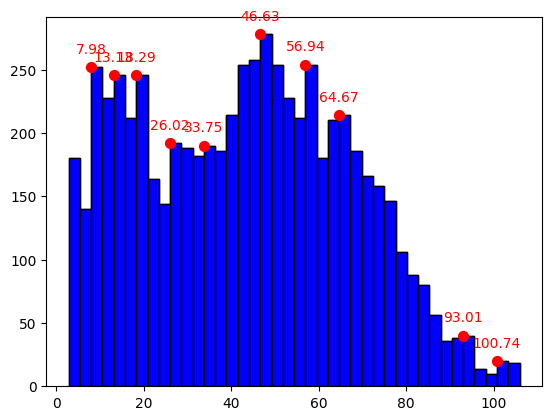

In [11]:
ft.distances_and_peaks(duck_distances)


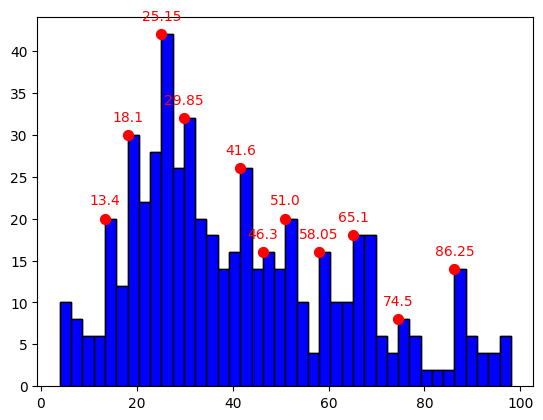

In [12]:
ft.distances_and_peaks(sps_distances)

In [17]:
# for instance, it seems that as a proximity parameter setting
# values around 20 should work well for sparrows, less so ducks
# values 50 should work well for ducks, not terribly for sparrows
# values around 80 should not work very well for either
# we'll keep these in mind as sanity checks

local_windows_kwargs = {
    "window_size": 20,  # in paper: locust sight goes beyond the grid
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}


predictor_kwargs = {
    "access": {
        "decay_factor": 0.2,
    },
}

# Emily wanted to try out all these values
# Rafal thinks these are too many options and prefers staying with 20, 50, and 80
# reason: histograms get cluttered and clarity is lost
optimal = [20, 50, 80] #[10, 20, 30, 40, 50, 60, 70, 80] 

for opt in optimal:
    predictor_kwargs[f"proximity_{opt}"] =  {
        "interaction_length": 90 / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "repulsion_radius": opt/2,
        "optimal_distance": opt,
        "proximity_decay": .5,
    }


score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

ducks_derivedDF = ft.derive_predictors_and_scores(
    ducks_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

sps_derivedDF = ft.derive_predictors_and_scores(
    sps_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)
display(ducks_derivedDF.head())

{'access': {'decay_factor': 0.2}, 'proximity_20': {'interaction_length': 30.0, 'interaction_constraint': None, 'interaction_constraint_params': {}, 'repulsion_radius': 10.0, 'optimal_distance': 20, 'proximity_decay': 0.5}, 'proximity_50': {'interaction_length': 30.0, 'interaction_constraint': None, 'interaction_constraint_params': {}, 'repulsion_radius': 25.0, 'optimal_distance': 50, 'proximity_decay': 0.5}, 'proximity_80': {'interaction_length': 30.0, 'interaction_constraint': None, 'interaction_constraint_params': {}, 'repulsion_radius': 40.0, 'optimal_distance': 80, 'proximity_decay': 0.5}}


2024-10-08 10:09:49,794 - access completed in 1.39 seconds.


In [ ]:
ngth": 90 / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "repulsion_radius": opt/2,
        "optimal_distance": opt,
        "proximity_decay": .5,
    },


score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

ducks_derivedDF = ft.derive_predictors_and_scores(
    ducks_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

sps_derivedDF = ft.derive_predictors_and_scores(
    sps_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)
display(ducks_derivedDF.head())